In [1]:
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets


In [2]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


In [3]:
mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [4]:
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples
train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset, batch_size=batch_size, num_workers=num_threads)
#valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads)
test_loader = torch.utils.data.DataLoader(dataset=mnist_testset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

The train set contains 60000 images, in 469 batches
The test set contains 10000 images, in 79 batches


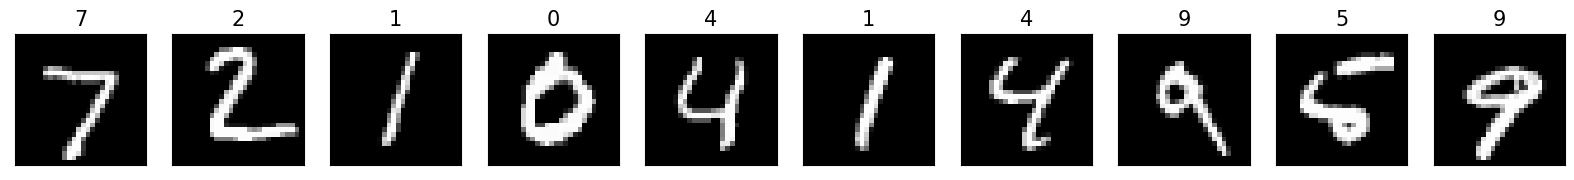

In [5]:
print("The train set contains {} images, in {} batches".format(len(train_loader.dataset), len(train_loader)))
print("The test set contains {} images, in {} batches".format(len(test_loader.dataset), len(test_loader)))
nsamples = 10
classes_names = ['0', '1', '2', '3', '4', '5','6', '7', '8', '9']
imgs_test, labels = next(iter(test_loader))
fig = plt.figure(figsize=(20,5))
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(imgs_test[i, 0, :, :], vmin=0, vmax=1.0, cmap=matplotlib.cm.gray)
    ax.set_title("{}".format(classes_names[labels[i]]), fontsize=15)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [6]:
class AE(nn.Module):
    def __init__(self, encoder, decoder, encoding_dim):
        super(AE, self).__init__()
        self.encoding_dims = encoding_dim
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
class VAE(AE):
    
    def __init__(self, encoder, decoder, encoding_dims, latent_dims):
        super(VAE, self).__init__(encoder, decoder, encoding_dims)
        self.latent_dims = latent_dims
        self.mu = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims))#, nn.ReLU())
        self.sigma = nn.Sequential(nn.Linear(self.encoding_dims, self.latent_dims), nn.Softplus())
        
    def encode(self, x):
        z = self.encoder(x)
        mu = self.mu(z)
        sigma = self.sigma(z)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde.reshape(-1, 1, 28, 28), kl_div
    
    def latent(self, x, z_params):
        mu, sigma = z_params
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        kl_div = (1/2) * (torch.sum(1 + torch.log(sigma ** 2) - (mu ** 2) - (sigma ** 2)))        
        return z, kl_div

In [8]:
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
        
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

def construct_encoder_decoder_complex(nin, n_latent = 16, n_hidden = 512, n_params = 0, n_classes = 1):
    
    
    # Encoder network
    encoder = nn.Sequential(
        nn.Conv2d(nin, out_channels= 64, kernel_size= 3),
        nn.ReLU(),
        # nn.MaxPool2d(2, 2),
        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size= 3),
        nn.ReLU(),
        # nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(128*24*24, n_hidden), nn.ReLU(),
        nn.Linear(n_hidden, n_hidden), nn.ReLU(),
        nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )

    # Decoder network
    decoder = nn.Sequential(
        nn.Linear(n_latent, n_hidden), nn.ReLU(),
        nn.Linear(n_hidden, n_hidden), nn.ReLU(),
        nn.Linear(n_hidden, 128*24*24), nn.ReLU(),
        Reshape((128,24,24)),
        nn.ConvTranspose2d(128,64,3),nn.ReLU(),
        nn.ConvTranspose2d(64,nin * n_classes,3),nn.ReLU(),
    )

   # decoder = nn.Sequential(decoder1,decoder2)
    return encoder, decoder

In [9]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
          nn.Flatten(),
          nn.Linear(nin, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
    )
    # Decoder network
    decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, n_hidden), nn.ReLU(),
          nn.Linear(n_hidden, nin * n_classes), nn.Sigmoid()
    )
    return encoder, decoder

In [10]:
# Reconstruction criterion
recons_criterion = torch.nn.MSELoss(reduction='none')

def compute_loss(model, x):
    beta = 1.5
    z_params = model.encode(x)
    z, DKL = model.latent(x,z_params)
    x_predis = model.decode(z)
    loss = torch.sum(recons_criterion(x,x_predis.reshape(-1, 1, 28, 28)))
    full_loss = - beta * DKL + loss
    return full_loss, DKL, loss

def train_step(model, x, optimizer):
    # Compute the loss.
    loss, kld, loss_tot = compute_loss(model, x)
    # Before the backward pass,£ zero all of the network gradients
    optimizer.zero_grad()
    # Backward pass: compute gradient of the loss with respect to parameters
    loss.backward()
    # Calling the step function to update the parameters
    optimizer.step()
    return loss, kld, loss_tot

In [11]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = 1 #:pour le complex #pour le normalimgs_test.shape[2] * imgs_test.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder_complex(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Construct the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [12]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('Resultat_VAE_chiffre/essai_convolutionnel_2')

In [13]:
def generate_and_save_images(model, epoch, test_sample):
    predictions, _ = model(test_sample)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, 0, :, :].detach(), cmap='gray')
        plt.axis('off')
    
    # Tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()
    return(fig)

epochs = 50
losses_kld = []
test_sample = imgs_test[0:16, :, :, :]
for epoch in range(1, epochs + 1):

    full_loss = torch.Tensor([0])
    kld = torch.Tensor([0])
    loss = torch.Tensor([0])
    # Forward pass: compute predicted y by passing x to the model.
    for i, (x, _) in enumerate(train_loader):
        full_loss_b, kld_b, loss_b= train_step(model, x, optimizer)
        full_loss += full_loss_b
        kld += kld_b
        loss += loss_b
    #for i, (x, _) in enumerate(valid_loader):
    #    train_step(model, x, optimizer)
    losses_kld.append(full_loss.detach().numpy())
    #print('Epoch: {}, Test set ELBO: {}'.format(epoch, full_loss))
    fig = generate_and_save_images(model, epoch, test_sample)

    
    writer.add_scalar('Loss/Loss_total',full_loss,epoch)
    writer.add_scalar('Loss/kld',kld,epoch)
    writer.add_scalar('Loss/loss',loss,epoch)
    writer.add_figure('washionMist_evolv',fig,epoch)
    writer.flush()

##metttre KL et losses dans writer

##ajouter writer.add_mbeding


KeyboardInterrupt: 

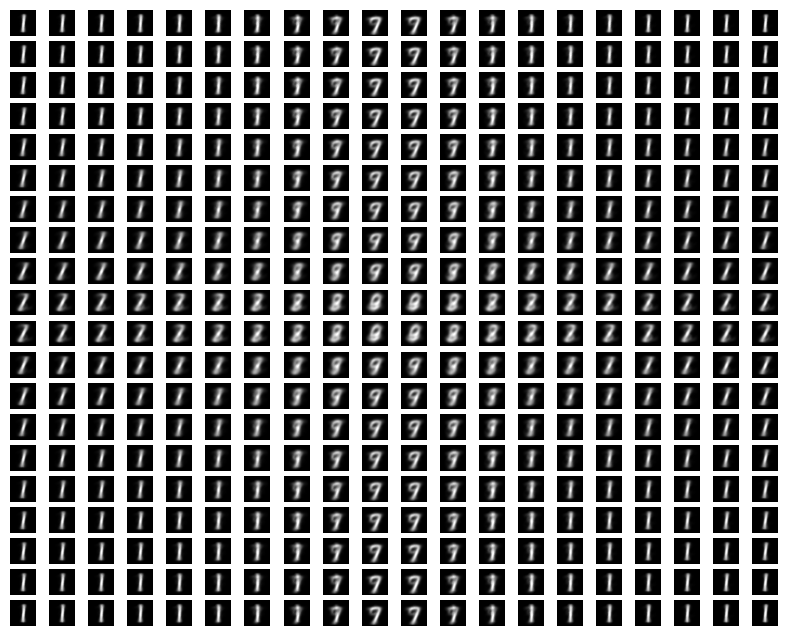

In [52]:
## en théorie y a que des trucs entre genre -3 et 3 (dans le range d'une gaussienne)

x = np.linspace(-3, 3, 20)
y = np.linspace(-3, 3, 20)
fig = plt.figure(figsize=(10, 8))
for i in range(20):
    for j in range(20):
        plt.subplot(20, 20, (i * 20) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model.decode(final_tensor).detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

In [40]:
def k(x,y,var):
    return(torch.exp(- abs(x - y)**2 / 2 / torch.std(x,y) ** 2))

def compute_mmd(x, y):

    MMD = torch.mean(k(x,x)) + torch.mean(k(y,y)) - 2 * torch.mean(k(x,y))
    return(MMD)